<a href="https://colab.research.google.com/github/fxlmer/Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Ex4_Ensemble_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from pj61403_utils_functions_Ver2 import *

# Git Clone

In [2]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

!git clone https://github.com/fxlmer/Skin-Diseases-Classification-Using-Machine-Learning

fatal: destination path 'PJ61403_DATA_split_50-25-25' already exists and is not an empty directory.
fatal: destination path 'Skin-Diseases-Classification-Using-Machine-Learning' already exists and is not an empty directory.


# WIDTH AND HEIGHT

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

NUM_CLASSES = 4

In [4]:
test_path = '/content/PJ61403_DATA_split_50-25-25/Ver2/crop_split_classes_data_Ver2/cc_test'

test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_data.flow_from_directory(directory=test_path,
                                               target_size=(IMG_WIDTH, IMG_HEIGHT),
                                               batch_size=1,
                                               shuffle=False,
                                               class_mode=None)

test_labels = test_generator.classes

Found 63 images belonging to 4 classes.


# Arithmetic Mean Ensemble

In [5]:
def ArithmeticMean_ensemble(test_data, model_1, model_2, model_3):
  model_1 = tf.keras.models.load_model(model_1)
  model_2 = tf.keras.models.load_model(model_2)
  model_3 = tf.keras.models.load_model(model_3)
  ans_1 = model_1.predict(test_data)
  ans_2 = model_2.predict(test_data)
  ans_3 = model_3.predict(test_data)
  all_answer_list = []
  for i in range(len(ans_1)):
    answer_list = []
    for j in range(len(ans_1[i])):
      mean_ans = (ans_1[i][j] + ans_2[i][j] + ans_3[i][j])/3
      answer_list.append(mean_ans)
    all_answer_list.append(answer_list)
  return all_answer_list

In [6]:
ensemble_ans = ArithmeticMean_ensemble(test_generator, '/content/Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex3/model_weights/Ex3_PJ61403_DenseNet121_Oversampling_model_Ver2.h5', '/content/Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex3/model_weights/Ex3_PJ61403_DenseNet121_ClassWeights_model_Ver2.h5', '/content/Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex3/model_weights/Ex3_PJ61403_DenseNet121_FocalLoss_model_Ver2.h5')

In [7]:
ensemble_ans_array = np.asarray(ensemble_ans)

# Evaluation

In [8]:
classes_names = ['ad', 'nm', 'ps', 'sk']

## Confusion Matrix

In [9]:
cm = confusion_matrix(test_labels, ensemble_ans_array.argmax(axis=1))

### Without Normalize

Confusion matrix, without normalization
[[17  0  0  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]


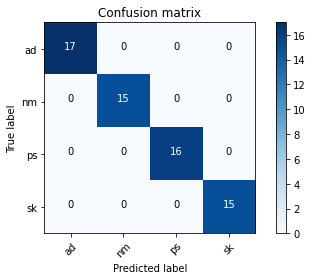

In [10]:
plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


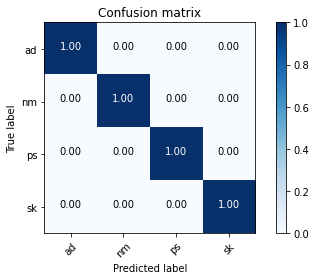

In [11]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [12]:
y_pred = np.argmax(ensemble_ans_array, axis=1)
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Classification Report
              precision    recall  f1-score   support

          ad       1.00      1.00      1.00        17
          nm       1.00      1.00      1.00        15
          ps       1.00      1.00      1.00        16
          sk       1.00      1.00      1.00        15

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



## TP FP FN TN

In [13]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [14]:
TruePositive= np.diag(cm_2)

In [15]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[17 15 16 15]
Sum of True Positive:  63


### FP

In [16]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [17]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[0, 0, 0, 0]
Sum of False Positive:  0


### FN

In [18]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [19]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[0, 0, 0, 0]
Sum of False Negative:  0


### TN

In [20]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [21]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[46, 48, 47, 48]
Sum of True Negative:  189


### Check TP + FP +FN + TN = Test set

In [22]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True


## PYCM

In [23]:
!pip3 install pycm==3.0

In [24]:
from pycm import *

In [25]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [26]:
py_cm.classes

[0, 1, 2, 3]

In [27]:
py_cm.table

{0: {0: 17, 1: 0, 2: 0, 3: 0},
 1: {0: 0, 1: 15, 2: 0, 3: 0},
 2: {0: 0, 1: 0, 2: 16, 3: 0},
 3: {0: 0, 1: 0, 2: 0, 3: 15}}

In [28]:
print(py_cm)

Predict  0        1        2        3        
Actual
0        17       0        0        0        

1        0        15       0        0        

2        0        0        16       0        

3        0        0        0        15       





Overall Statistics : 

95% CI                                                            (1.0,1.0)
ACC Macro                                                         1.0
ARI                                                               1.0
AUNP                                                              1.0
AUNU                                                              1.0
Bangdiwala B                                                      1.0
Bennett S                                                         1.0
CBA                                                               1.0
CSI                                                               1.0
Chi-Squared                                                       189.0
Chi-Squared DF          

### Average AUC

In [29]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3])/len(py_cm.AUC)

In [30]:
print('Average AUC: ', AV_AUC)

Average AUC:  1.0


### Average Senstivity

In [31]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3])/len(py_cm.TPR)

In [32]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  1.0


### Average Specificity

In [33]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3])/len(py_cm.TNR)

In [34]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  1.0
